# Other datasets

To also include additional files within the object store including footprints, emissions [+boundary conditions+] you can do this by accessing the underlying methods and reading in the file.

At the moment, the expected format for these files is created through standard methods from within the ACRG repository.

Before starting we need to define where our object store is located. If using a local compute resource please set this to your local work directory or a directory suitable for writing a large number of files to.

In [1]:
import os
import matplotlib.pyplot as plt
from openghg.localclient import get_obs_surface
from openghg.modules import Emissions, FOOTPRINTS, ObsSurface
from openghg.processing import footprints_data_merge, search

# object_store = "/work/<username>/object_store"

# Or to create a temporary object store if testing on your local machine
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
object_store = tmp_dir.name  # "/tmp/openghg_store"

os.environ["OPENGHG_PATH"] = object_store

### Observations

See [workflow.ipynb](workflow.ipynb#2.-Processing-data) tutorial notebook for how to add observation files to the object store, as well as how to access and use this data. For this example we need to make sure observations from the Tacolneston (TAC) site as part of the DECC network are within the Object store.

In [2]:
site="tac" 
network="DECC"
height="100m"
domain="EUROPE"
species="ch4"

In [3]:
obs_file = "../data/DECC/tac.picarro.1minute.100m.test.dat"

ObsSurface.read_file(filepath=obs_file, data_type="CRDS", site=site, network=network, inlet=height)

Processing: tac.picarro.1minute.100m.test.dat: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


defaultdict(dict,
            {'processed': {'tac.picarro.1minute.100m.test.dat': {'ch4': 'b679dcee-2148-4562-a97c-232c0915af61',
               'co2': '462c76b0-b3a0-409a-8527-339bc97ca3a3'}}})

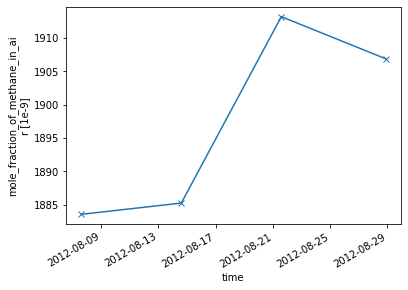

In [4]:
start_date = "2012-08-01"
end_date = "2012-09-01"

obs = get_obs_surface(site=site, species=species, start_date=start_date,
                        end_date=end_date, inlet=height, network=network)

mf = obs.data["mf"]
mf.plot(marker="x")

### Footprints

In [5]:
fp_file_path = "../data/footprints/TAC-100magl_EUROPE_201208.nc"

site="tac" 
height="100m"
domain="EUROPE"
model="NAME"

FOOTPRINTS.read_file(filepath=fp_file_path, site=site, height=height, domain=domain, model=model)

{'tac_europe_NAME_100m': '057bde5c-a01c-4b64-9409-1b14988b1237'}

### Emissions

In [6]:
flux_file_path = "../data/emissions/ch4-anthro_EUROPE_2012.nc"

species="ch4"
domain="EUROPE"
source="anthro"
date = "2012"

Emissions.read_file(filepath=flux_file_path, species=species, source=source, domain=domain, date=date)

{'ch4_anthro_europe_2012': '3ea11c67-59fa-4b2f-8609-b7f5308fb4f2'}

### Footprints data merge



In [7]:
start_date = "2012-01-01"
end_date = "2013-01-01"

site = "tac" 
height = "100m"
species = "ch4"
domain ="EUROPE"
model = "NAME"
network = "decc"

CombinedData = footprints_data_merge(site=site, height=height, network=network, domain=domain, 
                                    start_date=start_date, end_date=end_date, species=species,
                                    flux_sources=source, load_flux=True, calc_timeseries=True)
    
data = CombinedData.data

/work/rt17603/environments/openghg/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


TypeError: Invalid type <class 'str'>. Must be int or float.

In [ ]:
# Calculate modelled mole fraction based on emissions estimate
mf_mod = data["mf_mod"]

# Add a sensible baseline
baseline = mf.quantile(0.01).drop("quantile")
print(f"Estimating baseline based on 1st percentile of data: {baseline.values}")

mf_mod = mf_mod + baseline

In [ ]:
# Plot mole fraction data versus modelled mole fraction based on emissions estimate

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

mf.plot(marker="x", ax=ax, label="Measured mole fraction")
mf_mod.plot(marker="o", ax=ax, label="Modelled mole fraction")

ax.legend()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## IDEALLY WOULD WANT TO LOAD CARTOPY HERE

fig, ax = plt.subplots()

## Plot footprints as a 2D colour map
data_fp = data["fp"].isel(time=0) # First time point
lat = data_fp.lat
lon = data_fp.lon
footprint = data_fp.values

vmin = 1e-5 # min is 0 and can't use 0 for a log scale
vmax = footprint.max()

im = ax.pcolormesh(lon, lat, footprint, 
              norm=colors.LogNorm(vmin=vmin, 
                                  vmax=vmax), shading="auto") # Put on a log scale
cb = plt.colorbar(im, ax=ax)
cb.set_label("Footprint")

## Add station position
attrs = data.attrs
if "station_longitude" in attrs and "station_latitude" in attrs:
    station_lon = data.attrs["station_longitude"]
    station_lat = data.attrs["station_latitude"]
    ax.scatter([station_lon],[station_lat])